In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image

/Users/bertramsillesen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/bertramsillesen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/bertramsillesen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/bertramsillesen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/bertramsillesen/miniforge3/envs/IntelligentSystems/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/bertramsillesen/miniforge3/envs/IntelligentSystems/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/bertramsillesen/miniforge3/envs/IntelligentSystems/bin/../lib/li

Create the dataset:

In [2]:
class FruitDatabase(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes
        

Transform images and paths:

In [3]:
DATA_DIR = "/Users/bertramsillesen/Desktop/archive/Fruit-262"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

full_dataset = FruitDatabase(DATA_DIR, transform=transform)

print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Example classes: {full_dataset.classes[:5]}")

Number of classes: 2
Example classes: ['abiu', 'acai']


Training, validation and data-split:

In [4]:
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Create Pytorch model:

In [5]:
class SimpleFruitClassifier(nn.Module):
    def __init__(self, num_classes=2, backbone_name="efficientnet_b0", pretrained=True):
        super().__init__()

        backbone = timm.create_model(backbone_name, pretrained=pretrained)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        self.feature_dim = backbone.num_features
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

Device pick:

In [6]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print("Using device:", device)

Using device: mps


Setup for training:

In [7]:
NUM_CLASSES = 2   # change to 262 when ready
NUM_EPOCHS = 5
LR = 1e-3

model = SimpleFruitClassifier(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []

Training and validation loop:

In [8]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Val"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f}"
    )

Epoch 1 - Val: 100%|██████████| 12/12 [00:01<00:00,  9.08it/s]


Epoch 1/5 | Train loss: 0.0777 | Val loss: 0.0170


Epoch 2 - Val: 100%|██████████| 12/12 [00:00<00:00, 15.46it/s]


Epoch 2/5 | Train loss: 0.0362 | Val loss: 0.0799


Epoch 3 - Val: 100%|██████████| 12/12 [00:00<00:00, 15.23it/s]


Epoch 3/5 | Train loss: 0.0388 | Val loss: 0.0175


Epoch 4 - Val: 100%|██████████| 12/12 [00:00<00:00, 16.08it/s]


Epoch 4/5 | Train loss: 0.0175 | Val loss: 0.0589


Epoch 5 - Val: 100%|██████████| 12/12 [00:00<00:00, 16.67it/s]

Epoch 5/5 | Train loss: 0.0223 | Val loss: 0.0621


Loss plot on training and test data:

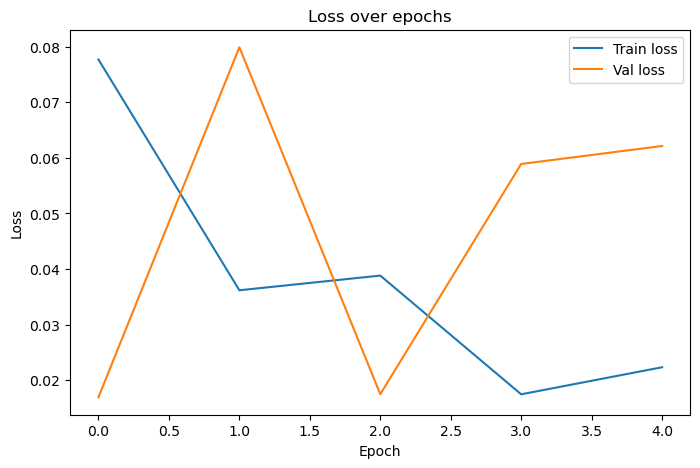

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Evaluation and visualization

In [10]:
def evaluate_and_visualize(
    model,
    dataloader,
    dataset,
    device,
    max_images=16
):
    model.eval()

    correct = 0
    total = 0
    failed_samples = []

    class_names = dataset.classes

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # collect failures
            for i in range(images.size(0)):
                if preds[i] != labels[i]:
                    failed_samples.append({
                        "image": images[i].cpu(),
                        "true": labels[i].item(),
                        "pred": preds[i].item()
                    })

    accuracy = correct / total if total > 0 else 0.0
    print(f"\nTest accuracy: {accuracy:.4f}")
    print(f"Total failed samples: {len(failed_samples)} / {total}")

    # Visualization of FAILED samples
    num_show = min(max_images, len(failed_samples))

    if num_show == 0:
        print("No misclassified samples to visualize 🎉")
        return

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_show):
        sample = failed_samples[i]
        img = sample["image"].permute(1, 2, 0)

        true_label = class_names[sample["true"]]
        pred_label = class_names[sample["pred"]]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(
            f"P: {pred_label}\nT: {true_label}",
            color="red",
            fontsize=9
        )

    for j in range(num_show, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Misclassified Test Images", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print failed labels (text)
    print("\nFirst failed predictions:")
    for i, sample in enumerate(failed_samples[:20]):
        print(
            f"{i+1:02d}. True: {class_names[sample['true']]} | "
            f"Predicted: {class_names[sample['pred']]}"
        )

Run the evaluation:

In [11]:
evaluate_and_visualize(
    model=model,
    dataloader=test_loader,
    dataset=full_dataset,
    device=device,
    max_images=16
)


Test accuracy: 1.0000
Total failed samples: 0 / 358
No misclassified samples to visualize 🎉
